# 1-D Inference with Redshifts

Part 1.5 of a series of notebooks used to derive the results shown in Speagle et al. (2017).

This notebook outlines how to derive population redshift distributions from a given collection of **redshift probability density functions (PDFs)**. This simple case allows us to introduce most of the critical ideas and extensions that will be applied to $p$-D **photometric redshift (photo-z) PDF** inference in later notebooks.

## Setup

In [1]:
import sys # system commands
import pickle # saving data
from scipy import stats # statistics functions
from scipy import special # special functions
from scipy import interpolate # interpolation
from sklearn.neighbors import KernelDensity # kernel density estimation

# simulation
import make_sim as sim

# FRANKEN-Z
import frankenz as fz

%pylab
%matplotlib inline

# re-defining plotting defaults
from matplotlib.font_manager import FontProperties
from matplotlib import gridspec
rcParams.update({'xtick.major.pad': '7.0'})
rcParams.update({'xtick.major.size': '7.5'})
rcParams.update({'xtick.major.width': '1.5'})
rcParams.update({'xtick.minor.pad': '7.0'})
rcParams.update({'xtick.minor.size': '3.5'})
rcParams.update({'xtick.minor.width': '1.0'})
rcParams.update({'ytick.major.pad': '7.0'})
rcParams.update({'ytick.major.size': '7.5'})
rcParams.update({'ytick.major.width': '1.5'})
rcParams.update({'ytick.minor.pad': '7.0'})
rcParams.update({'ytick.minor.size': '3.5'})
rcParams.update({'ytick.minor.width': '1.0'})
rcParams.update({'xtick.color': 'k'})
rcParams.update({'ytick.color': 'k'})
rcParams.update({'font.size': 30})

Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


## Data

For our proof-of-concept tests, we will use the mock SDSS data we previously generated.

In [2]:
sdss = pickle.load(open( "mock_sdss_cosmos_bpz.p", "rb" )) # load data
[types, redshifts, mags], templates = sdss.samples, sdss.samples_t # import truth labels

## $dN/dz$ Estimation

### Noiseless Case

For every observed galaxy $g \in \mathbf{g}$, we have an associated redshift estimate $z_g$ with no measurement errors such that the corresponding redshift PDF is $P(z|z_g)=\delta(z=z_g)$. We can construct an estimate for the population redshift distribution by projecting our results onto a relevant **redshift basis** $\lbrace \dots, P(z|z_h) , \dots \rbrace$ indexed by $h \in \mathbf{h}$ via

$$
P(z_g|z_h) \equiv P(g|h) = \int P(z|z_h) P(z|z_g) P(z) dz \quad .
$$

One common choice of basis is a series of redshift **bins**, which can be modeled as a product of Heavyside functions

$$
P(z|z_h) = \mathcal{H}(z - z_h^{i})\mathcal{H}(z_h^{+} - z), \quad z_h^{\pm} = (z_h \pm \Delta z_h)/2
$$

where $z_h^{\pm}$ are the bin edges for bin center $z_h$ and bin width $\Delta z_h$. Assuming our redshift prior $P(z)$ is uniform, $P(g|h)$ then becomes $1$ if $z_h^{-} < z_g \leq z_h^{+}$ and $0$ otherwise.

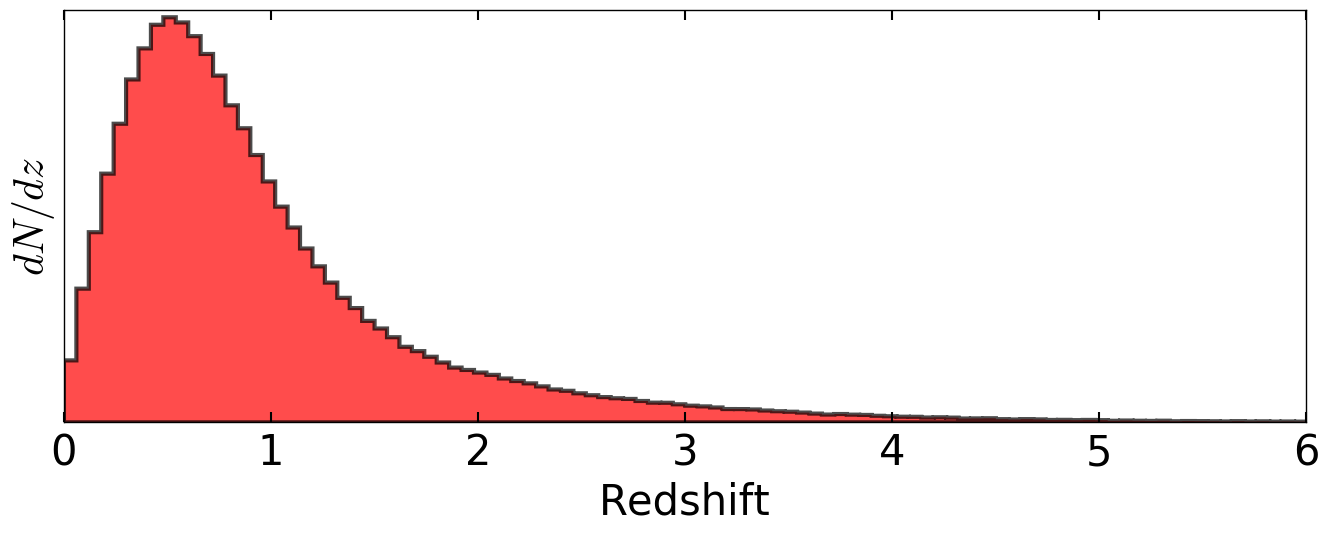

In [3]:
zbins = linspace(0,6,100+1) # redshift bins

# plotting
figure(figsize=(14,6))
h = hist(redshifts, bins=zbins, histtype='stepfilled', lw=3, color='red', alpha=0.7, normed=True)
xlabel('Redshift')
yticks([])
ylabel('$dN/dz$')
tight_layout()

Alternately, we can construct a smooth density estimate by "flipping" the roles played by our $P(z|z_g)$'s and $P(z|z_h)$'s. Using **kernel density estimation**, we can approximate the underlying density spanned by all $z_g$'s by assigning each $z_g$ a corresponding kernel density $K_g(z|z_g)$.

Let's choose a Normal (Gaussian) kernel centered at $\hat{z}_g$ with smoothing scale $\sigma=0.01$ such that $P(z|z_g) = K_g(z|z_g)=\mathcal{N}(z|\mu=\hat{z}_g, \sigma^2=10^{-4})$, and $P(z|z_h)=\delta(z=z_h)$ to be the "redshift grid" (indexed by $h$) we use to evaluate our density estimate. Using some functionality from FRANKEN-Z, we compute and plot this below.

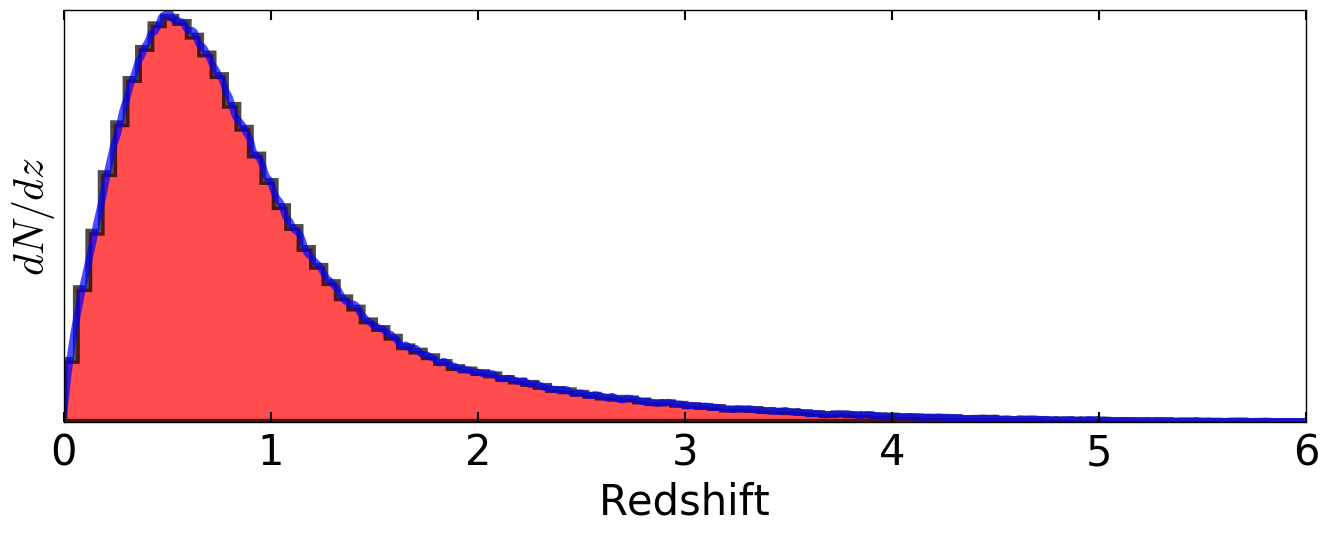

In [4]:
# redshift grid
dz, Nz = 0.01, 600+1
zgrid = arange(0, dz*Nz, dz)

# KDE
pdf = fz.pdf_kde(redshifts, ones(sdss.NSAMPLES)*dz, ones(sdss.NSAMPLES), zgrid, dz, sdss.NSAMPLES, Nz)
pdf /= trapz(pdf, zgrid)

# plotting
figure(figsize=(14,6))
h = hist(redshifts, bins=zbins, histtype='stepfilled', lw=5, color='red', alpha=0.7, normed=True)
plot(zgrid, pdf, lw=5, color='blue', alpha=0.7)
xlabel('Redshift')
yticks([])
ylabel('$dN/dz$')
tight_layout()

### Noisy Case

Now let's imagine that we don't actually have access to $z_g$, but only the corresponding redshift PDF $P(z|z_g)$. Our estimate for $dN/dz$ is identical to our KDE case from above, except our original kernels $K_g(z|z_g)$ are now centered around the noisy estimates $\hat{z}_g$ and their associated widths $\sigma_g$ can now vary.

In [5]:
# generate PDFs
sigma = uniform(0.01, 0.1, size=sdss.NSAMPLES) # width
mu = normal(redshifts, sigma) # noisy observation
zpdf = array([fz.gaussian(mu[i], sigma[i], zgrid) for i in xrange(sdss.NSAMPLES)]) # redshift pdfs
zpdf /= trapz(zpdf, zgrid)[:,None] # normalizing

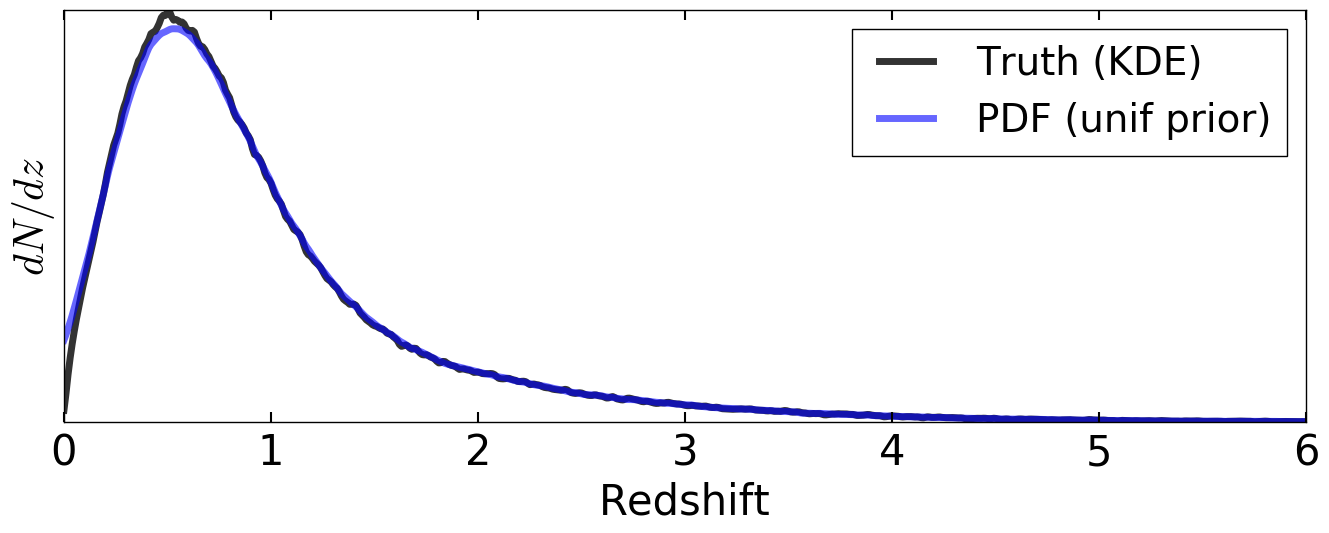

In [6]:
# plotting
figure(figsize=(14,6))
plot(zgrid, pdf, lw=5, color='black', alpha=0.8, label='Truth (KDE)')
plot(zgrid, zpdf.sum(axis=0) / sdss.NSAMPLES, lw=5, color='blue', alpha=0.6, label='PDF (unif prior)')
xlabel('Redshift')
yticks([])
ylabel('$dN/dz$')
legend(fontsize=28, loc='best')
tight_layout()

Now that we're using PDFs instead of the true observed estimates, we can see how our noise broadens our estimated $dN/dz$ distribution. To properly account for this, we need to re-introduce our **prior** $P(z)$. Over our redshift grid $\mathbf{z} = \lbrace \dots, z_h, \dots \rbrace$, this then gives

$$
P(\mathbf{z}|g) = \int P(z|z_h) P(z|z_g) P(z) dz \propto \mathcal{N}(\mathbf{z}|\hat{z}_g, \sigma_g^2) P(\mathbf{z}) \quad .
$$

For our prior, let's put in the true redshift distribution computed previously using KDE.

In [11]:
znew = zpdf.copy()
for i in xrange(sdss.NSAMPLES):
    znew[i] *= pdf
    znew[i] /= trapz(znew[i], zgrid)

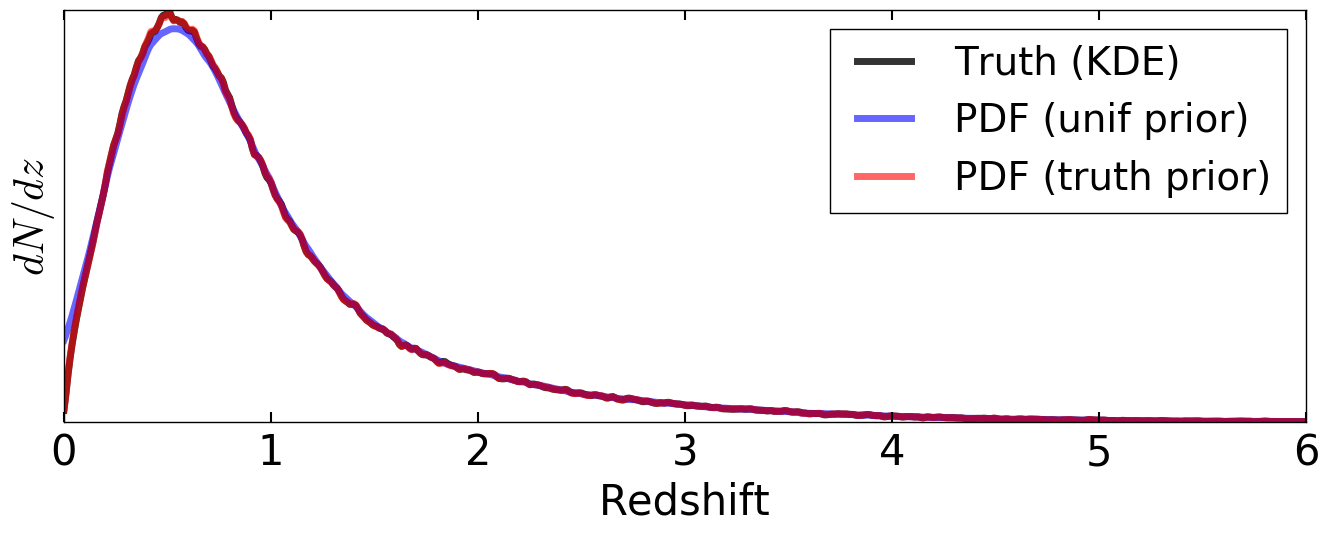

In [12]:
# plotting
figure(figsize=(14,6))
plot(zgrid, pdf, lw=5, color='black', alpha=0.8, label='Truth (KDE)')
plot(zgrid, zpdf.sum(axis=0) / sdss.NSAMPLES, lw=5, color='blue', alpha=0.6, label='PDF (unif prior)')
plot(zgrid, znew.sum(axis=0) / sdss.NSAMPLES, lw=5, color='red', alpha=0.6, label='PDF (truth prior)')
xlabel('Redshift')
yticks([])
ylabel('$dN/dz$')
legend(fontsize=28, loc='best')
tight_layout()

## From Grids to Samples

So far we've assumed that our basis functions $h \in \mathbf{h}$ correspond to a grid in redshift $z_h \in \mathbf{z}$. Above, we found that to properly reproduce the true $dN/dz$ we need to incorporate a proper redshift prior $P(z)$. Given our discrete grid, this translates to a set of discrete priors $P(z_h) \equiv P(h)$ over $\mathbf{h}$. Adopting our original notation, this quickly gives rise to **Bayes theorem**

$$
P(h|g) = \frac{P(g|h) P(h)}{P(g)} \propto P(g|h) P(h)
$$

where

$$
P(g|h) \equiv \int P(z|h) P(z|g) dz, \quad P(h) = \frac{\int P(z|h) P(z|g) P(z) dz}{\int P(z|h) P(z|g) dz} \quad .
$$

For the case that $P(z|h) = \delta(z=z_h)$ (i.e. point estimates), this immediately reduces to $P(g|h) = P(z_h|g)$, $P(h) = P(z_h)$. If, however, our underlying set of basis functions are *not* point estimates, then we'd nominally have to compute the whole integral.

We now want to take advantage of two key insights:
1. Our choice of basis is arbitrary, and we're free to pick our $h \in \mathbf{h}$ and corresponding $P(z|h)$ however we'd like (in general), and
2. Our basis can provide information on our prior.

In particular, if we assume that $h \in \mathbf{h}$ is a **point process** drawn from the underlying $P(z)$ distribution (i.e. the "true" prior), then aggregating information over these redshift samples is *fundamentally equivalent* (in the limit where $n \rightarrow \infty$) to weighting a set of predictions computed over a redshift grid $\mathbf{z}$ by our corresponding prior $P(\mathbf{z})$.

From a machine learning perspective, we can interpret these samples as a **training set** that we exploit to make predictions. See Speagle et al. (2017) for more details.

### Noiseless Samples

We first consider the case where our samples are noiseless and drawn directly from the redshift distribution of interest.

In [58]:
Ntrain = 1000 # number of training samples

In [59]:
cdf = pdf.cumsum()/pdf.sum() # compute CDF
ztrain = interp(rand(Ntrain), cdf, zgrid) # sample from underlying distribution

In [60]:
# stack results
ztrain_wt = zeros(Ntrain)
znorm = zeros(sdss.NSAMPLES)
for i in arange(sdss.NSAMPLES):
    if i%20000 == 0: sys.stdout.write(str(i)+' ')
    chi2 = ((ztrain - mu[i]) / sigma[i])**2
    chi2min = chi2.min()
    wt = exp(-0.5*(chi2-chi2min))
    norm = wt.sum()
    znorm[i] = norm / exp(-0.5*chi2min)
    ztrain_wt += wt/norm

0 20000 40000 60000 80000 100000 120000 140000 160000 180000 200000 220000 240000 260000 280000 300000 320000 340000 360000 380000 400000 420000 440000 460000 480000 

We then can estimate $dN/dz$ as before using KDE.

In [61]:
# KDE
pdftrain = fz.pdf_kde(ztrain, ones(Ntrain)*dz, ztrain_wt, zgrid, dz, Ntrain, Nz)
pdftrain /= trapz(pdftrain, zgrid)

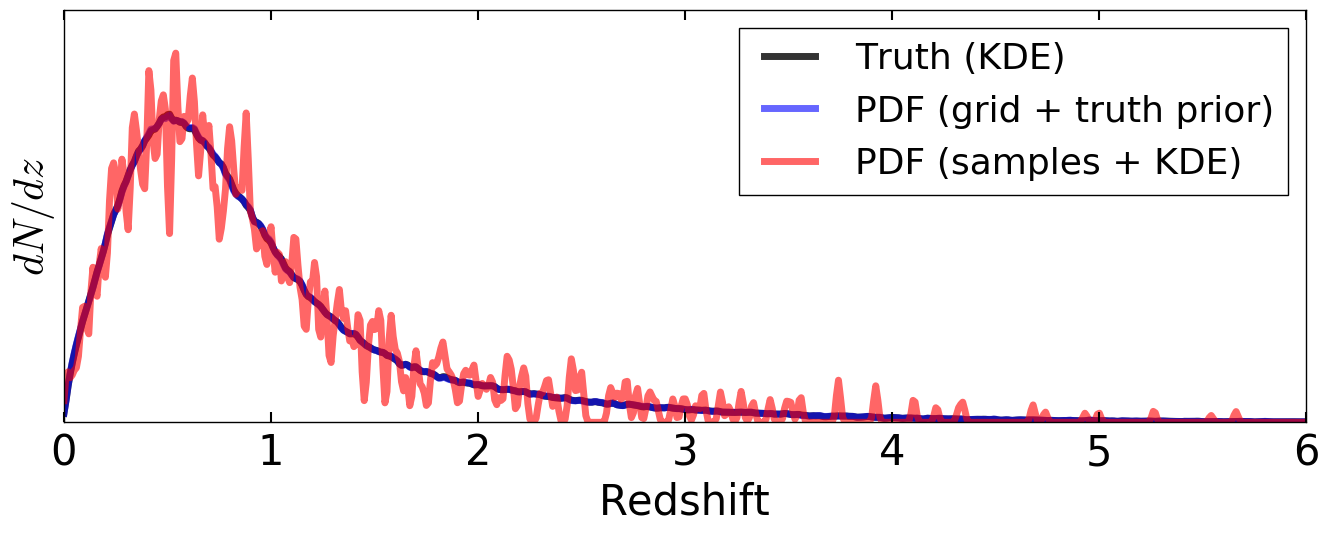

In [62]:
# plotting
figure(figsize=(14,6))
plot(zgrid, pdf, lw=5, color='black', alpha=0.8, label='Truth (KDE)')
plot(zgrid, znew.sum(axis=0) / sdss.NSAMPLES, lw=5, color='blue', alpha=0.6, label='PDF (grid + truth prior)')
plot(zgrid, pdftrain, lw=5, color='red', alpha=0.6, label='PDF (samples + KDE)')
xlabel('Redshift')
yticks([])
ylabel('$dN/dz$')
legend(fontsize=26, loc='best')
tight_layout()

While this estimate is accurate overall, it's subject to a some additional noise due to sampling variance. As a result, it relies on there being a *lot* of samples available for estimation, especially if we want to probe the tails of the redshift distribution.

### Noisy Samples

We now consider the case where our samples/training data are *also* noisy redshift estimates characterized by $P(z|h)$. As with the switch from noiseless to noisy redshifts for $g \in \mathbf{g}$, this switch for $h \in \mathbf{h}$ is again equivalent to KDE, except now our kernels can have variables widths. The likelihood for each kernel is then

$$
P(g|h) = \int P(z|h) P(z|g) dz = \int \mathcal{N}(z|\hat{z}_h, \sigma_h^2) \mathcal{N}(z|\hat{z}_g, \sigma_g^2) dz = \mathcal{N}(\hat{z}_g-\hat{z}_h|0,\sigma_g^2+\sigma_h^2) \quad .
$$

In [63]:
# sample redshifts
ztrain = interp(rand(Ntrain), cdf, zgrid)

# generate PDFs
sigma_train = uniform(0.01, 0.1, size=Ntrain) # width
var_train = sigma_train**2
mu_train = normal(ztrain, sigma_train) # noisy observation

In [64]:
# stack results
ztrain_wt2 = zeros(Ntrain)
znorm2 = zeros(sdss.NSAMPLES)
for i in arange(sdss.NSAMPLES):
    if i%20000 == 0: sys.stdout.write(str(i)+' ')
    chi2 = (mu_train - mu[i])**2 / (sigma[i]**2 + var_train)
    chi2min = chi2.min()
    wt = exp(-0.5*(chi2-chi2min))
    norm = wt.sum()
    znorm2[i] = norm / exp(-0.5*chi2min)
    ztrain_wt2 += wt/norm

0 20000 40000 60000 80000 100000 120000 140000 160000 180000 200000 220000 240000 260000 280000 300000 320000 340000 360000 380000 400000 420000 440000 460000 480000 

We now stack the corresponding kernels.

In [65]:
# KDE
pdftrain2 = fz.pdf_kde(mu_train, sigma_train, ztrain_wt2, zgrid, dz, Ntrain, Nz)
pdftrain2 /= trapz(pdftrain2, zgrid)

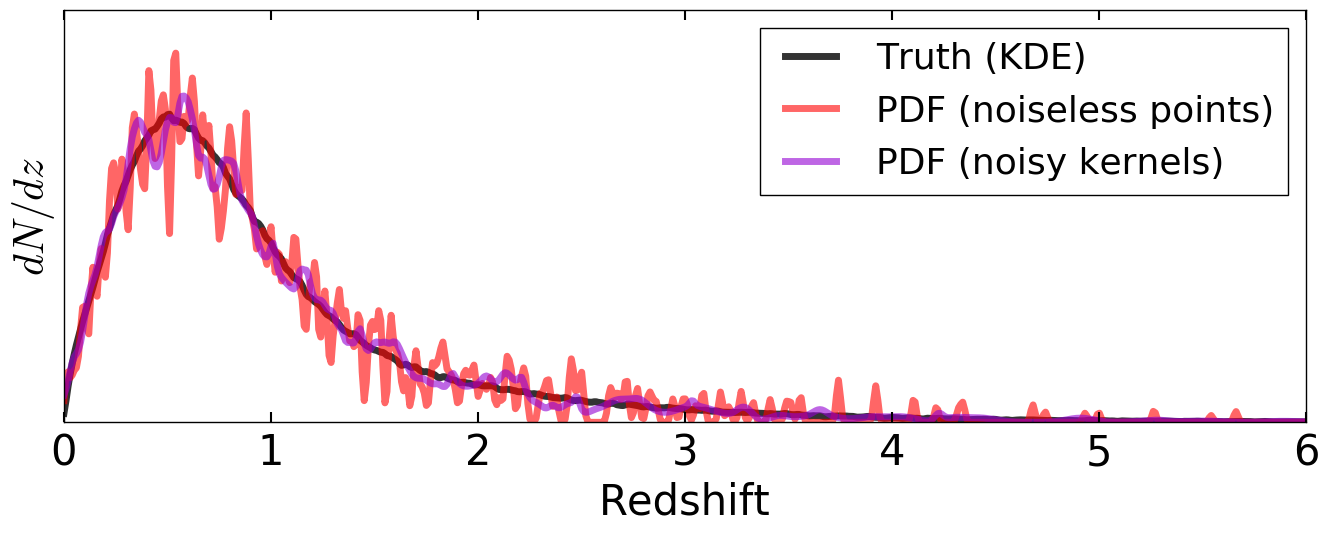

In [66]:
# plotting
figure(figsize=(14,6))
plot(zgrid, pdf, lw=5, color='black', alpha=0.8, label='Truth (KDE)')
plot(zgrid, pdftrain, lw=5, color='red', alpha=0.6, label=r'PDF (noiseless points)')
plot(zgrid, pdftrain2, lw=5, color='darkviolet', alpha=0.6, label=r'PDF (noisy kernels)')
xlabel('Redshift')
yticks([])
ylabel('$dN/dz$')
legend(fontsize=26, loc='best')
tight_layout()

By eye, it can immediately be seen that our PDF using the same number of "noisy" samples is actually a much better representation than our PDF using noiseless samples. What gives?

There are three reasons for this:
1. It makes a difference whether a probabilistic basis is incorporated directly into the likelihoods or implemented afterwards. In the noiseless case, we applied KDE afterwards rather than assigning each object its own kernel when deriving our likelihoods, which ignores the intrinsic width of the kernel.
2. The smoothing scale for our inference is set by the width of our kernels. In the noiseless case, we chose the same smoothing scale ($\Delta z = 0.01$) used for our grid, while for the noisy case our smoothing scale varies from $\Delta z = 0.01 - 0.1$. This sets the scale for variation, and since the total number of samples we are using is relatively small, we would expect a broader smoothing scale to give better results.
3. While each individual PDF from our noisy sample is a noisy draw from the underlying density, across the ensemble the noise generally averages out, giving an unbaised representation of the true underlying distribution.

Just to show the influence of these effects, we use a series of broader noiseless kernels to re-derive our $dN/dz$ below.

In [67]:
# sample redshifts
ztrain = interp(rand(Ntrain), cdf, zgrid)
smooth = 0.05

# stack results
ztrain_wt3 = zeros(Ntrain)
znorm3 = zeros(sdss.NSAMPLES)
for i in arange(sdss.NSAMPLES):
    if i%20000 == 0: sys.stdout.write(str(i)+' ')
    chi2 = (ztrain - mu[i])**2 / (sigma[i]**2 + smooth**2)
    chi2min = chi2.min()
    wt = exp(-0.5*(chi2-chi2min))
    norm = wt.sum()
    znorm3[i] = norm / exp(-0.5*chi2min)
    ztrain_wt3 += wt/norm

0 20000 40000 60000 80000 100000 120000 140000 160000 180000 200000 220000 240000 260000 280000 300000 320000 340000 360000 380000 400000 420000 440000 460000 480000 

In [68]:
# KDE
pdftrain3 = fz.pdf_kde(ztrain, ones(Ntrain)*smooth, ztrain_wt3, zgrid, dz, Ntrain, Nz)
pdftrain3 /= trapz(pdftrain3, zgrid)

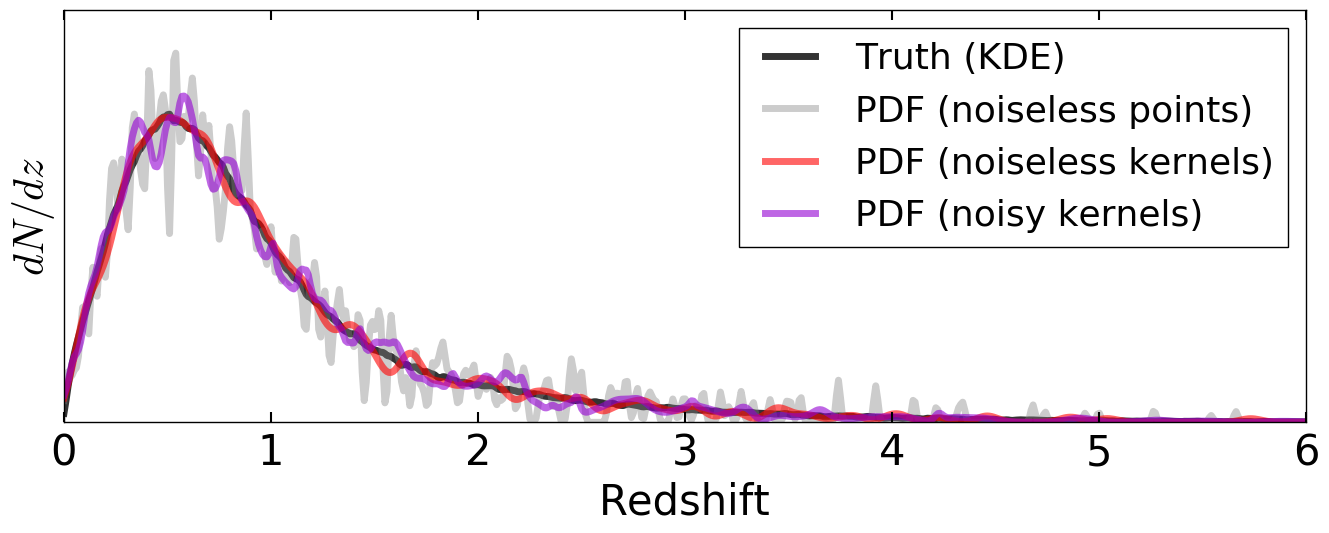

In [69]:
# plotting
figure(figsize=(14,6))
plot(zgrid, pdf, lw=5, color='black', alpha=0.8, label='Truth (KDE)')
plot(zgrid, pdftrain, lw=5, color='gray', alpha=0.4, label=r'PDF (noiseless points)')
plot(zgrid, pdftrain3, lw=5, color='red', alpha=0.6, label=r'PDF (noiseless kernels)')
plot(zgrid, pdftrain2, lw=5, color='darkviolet', alpha=0.6, label=r'PDF (noisy kernels)')
xlabel('Redshift')
yticks([])
ylabel('$dN/dz$')
legend(fontsize=26, loc='best')
tight_layout()

As expected, we do a significantly better job recovering the underlying distribution once we properly incorporate a set of broader kernels directly into our likelihoods.

### Sidenote: Coverage

One of the risks that becomes immediately apparent moving from grids to samples is the issue of **coverage**: our training data might not properly cover all of the space spanned by our observable PDFs. We can diagnose this by looking at the **evidence** $P(g)$ (i.e. the normalization) computed for our objects. This gives a direct probe that tells us how much of our basis of $P(z|h)$'s overlap with each individual $P(z|g)$. We can then choose a given threshold (say $P(g)>0.05$, i.e. that our kernels cimulatively overlap with at least 5% of the observed PDF) that signifies whether a given prediction can or cannot be trusted.

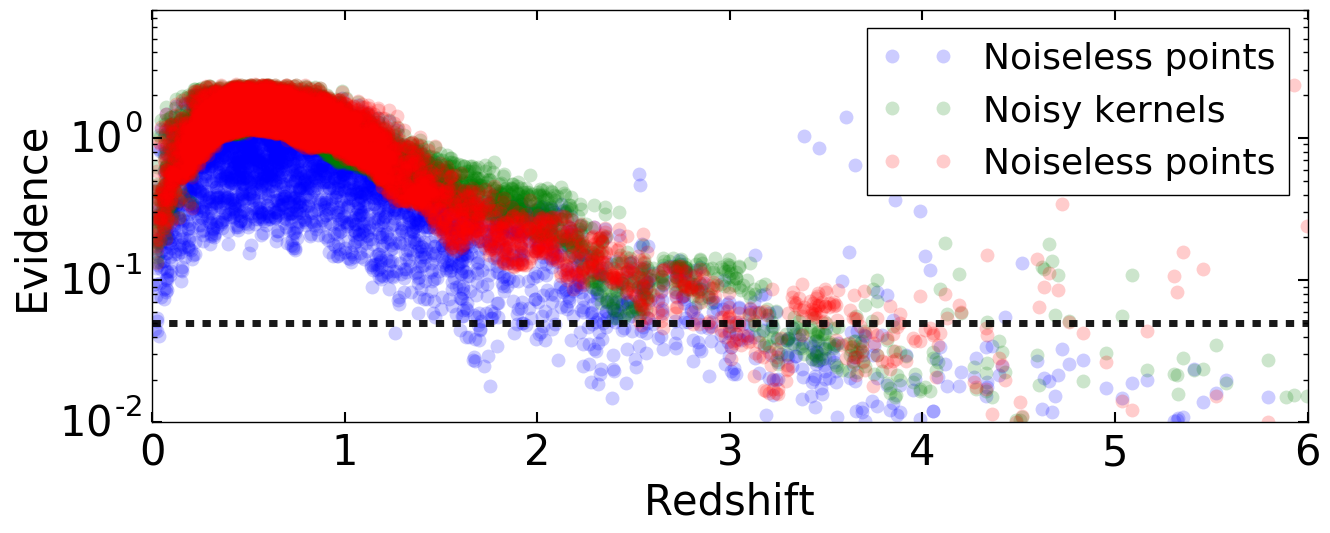

In [70]:
figure(figsize=(14,6))
semilogy(redshifts[::100], znorm[::100]*dz, 'o', markersize=10, alpha=0.2, label='Noiseless points', markeredgecolor='none')
semilogy(redshifts[::100], znorm2[::100]*dz, 'o', markersize=10, alpha=0.2, label='Noisy kernels', markeredgecolor='none')
semilogy(redshifts[::100], znorm3[::100]*dz, 'o', markersize=10, alpha=0.2, label='Noiseless points', markeredgecolor='none')
plot([0,6], [0.05, 0.05], color='black', lw=5, alpha=0.9, ls='--')
xlabel('Redshift')
ylim([None, 8])
ylabel('Evidence')
legend(fontsize=26, loc='best')
tight_layout()

As expected, this distribution traces the underlying redshift distribution (since we've sampled from the underlying redshift distribution), and we can see that in both cases several observed objects do not have enough coverage for our predictions be considered reliable.

## Hierarchical Inference

We now want to derive *errors* around our $dN/dz$ predictions from our underlying PDFs. While we can do this using our samples, we're going to go back to our model grid since those are more intuitive.

### Poisson Samples

A common approximation is the assume that the amplitude at each redshift is simply a Poisson process, with errors that go as $\sqrt{N}$. This is technically incorrect, since it assumes the distribution around the sum is the same as the sum of the distributions, but often is invoked as a first-order approximation.

In [132]:
Nsamples = 20 # number of dN/dz samples

In [133]:
pdf1 = zpdf.sum(axis=0) # stacked PDF
pdf1 /= pdf1.sum() # normalize
pdf1 *= sdss.NSAMPLES # sample size
pdf1_std = sqrt(pdf1) # Poisson error
pdf1_samples = array([normal(pdf1, pdf1_std) for i in xrange(Nsamples)]) # samples

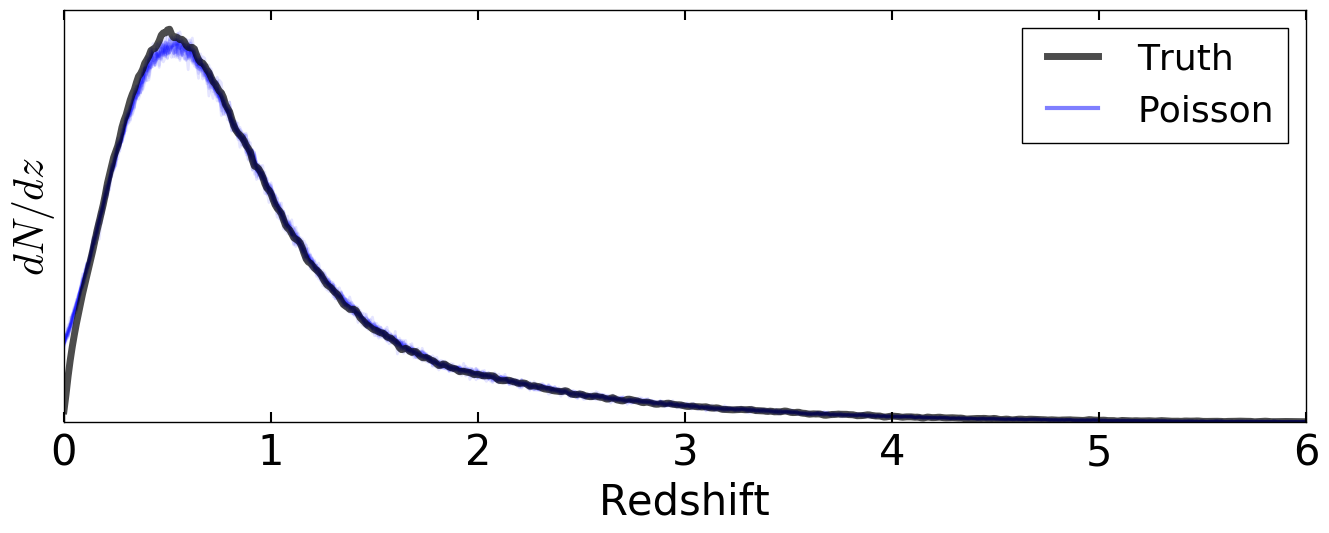

In [134]:
# plotting
figure(figsize=(14,6))
[plot(zgrid, pdf1_samples[i], lw=2, color='blue', alpha=0.1) for i in xrange(Nsamples)]
plot(zgrid, pdf/pdf.sum() * sdss.NSAMPLES, lw=5, color='black', alpha=0.7, label='Truth')
plot(zgrid, pdf*0.0-1e4, lw=3, color='blue', alpha=0.5, label='Poisson')
xlabel('Redshift')
yticks([])
ylim([0, max(pdf/pdf.sum() * sdss.NSAMPLES) * 1.05])
ylabel('$dN/dz$')
legend(fontsize=26, loc='best')
tight_layout()

### Posterior Samples

Assuming our PDFs are accurate, we can sample directly from them and stack the results to construct the $dN/dz$ directly.

In [135]:
pdf2_samples = zeros(pdf1_samples.shape)
for j in xrange(Nsamples):
    sys.stdout.write(' -- '+str(j)+' -- ')
    for i in xrange(sdss.NSAMPLES):
        if i%100000 == 0: sys.stdout.write(str(i)+' ')
        pdf2_samples[j] += multinomial(1, zpdf[i]/zpdf[i].sum()) # stack multinomial draw

 -- 0 -- 0 100000 200000 300000 400000  -- 1 -- 0 100000 200000 300000 400000  -- 2 -- 0 100000 200000 300000 400000  -- 3 -- 0 100000 200000 300000 400000  -- 4 -- 0 100000 200000 300000 400000  -- 5 -- 0 100000 200000 300000 400000  -- 6 -- 0 100000 200000 300000 400000  -- 7 -- 0 100000 200000 300000 400000  -- 8 -- 0 100000 200000 300000 400000  -- 9 -- 0 100000 200000 300000 400000  -- 10 -- 0 100000 200000 300000 400000  -- 11 -- 0 100000 200000 300000 400000  -- 12 -- 0 100000 200000 300000 400000  -- 13 -- 0 100000 200000 300000 400000  -- 14 -- 0 100000 200000 300000 400000  -- 15 -- 0 100000 200000 300000 400000  -- 16 -- 0 100000 200000 300000 400000  -- 17 -- 0 100000 200000 300000 400000  -- 18 -- 0 100000 200000 300000 400000  -- 19 -- 0 100000 200000 300000 400000 

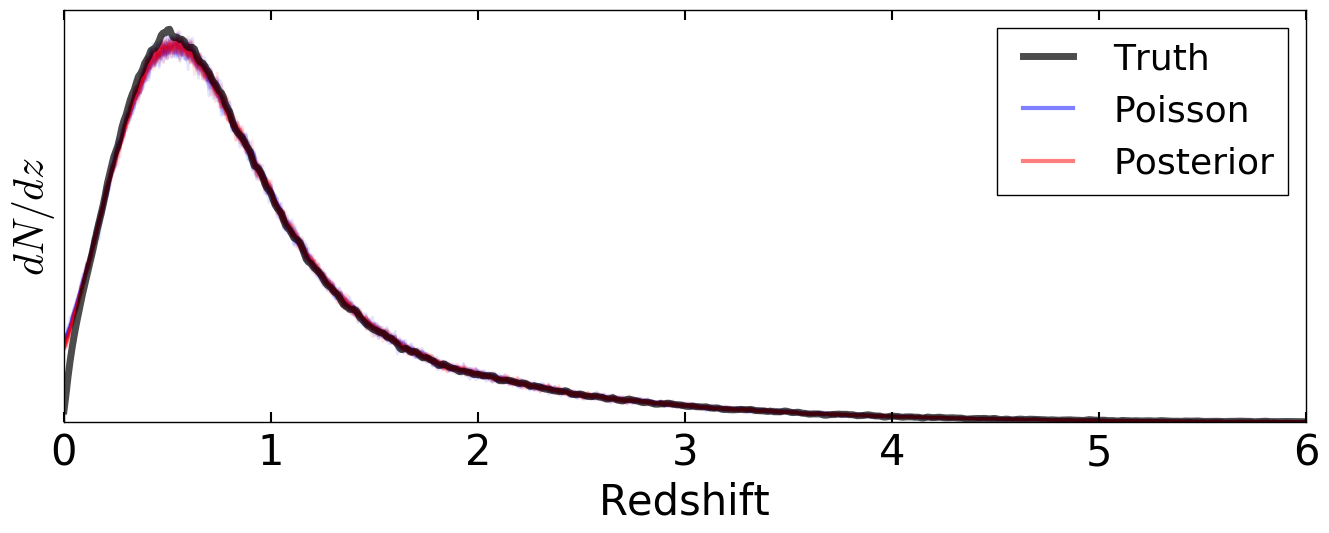

In [136]:
# plotting
figure(figsize=(14,6))
[plot(zgrid, pdf1_samples[i], lw=2, color='blue', alpha=0.1) for i in xrange(Nsamples)]
[plot(zgrid, pdf2_samples[i], lw=2, color='red', alpha=0.1) for i in xrange(Nsamples)]
plot(zgrid, pdf/pdf.sum() * sdss.NSAMPLES, lw=5, color='black', alpha=0.7, label='Truth')
plot(zgrid, pdf*0.0-1e4, lw=3, color='blue', alpha=0.5, label='Poisson')
plot(zgrid, pdf*0.0-1e4, lw=3, color='red', alpha=0.5, label='Posterior')
xlabel('Redshift')
yticks([])
ylim([0, max(pdf/pdf.sum() * sdss.NSAMPLES) * 1.05])
ylabel('$dN/dz$')
legend(fontsize=26, loc='best')
tight_layout()

### Population Weights

It can be shown (see Leistedt et al. 2016 and Speagle et al. 2017) that, given an observed set of counts $\mathbf{n}$, the corresponding set of population weights $\mathbf{w}$ over our redshift grid/samples is distributed as $\mathbf{w} \sim \textrm{Dir}(\mathbf{w}|\mathbf{n}+1)$.

In [137]:
pdf3_samples = zeros(pdf1_samples.shape)
for j in xrange(Nsamples):
    sys.stdout.write(' -- '+str(j)+' -- ')
    for i in xrange(sdss.NSAMPLES):
        if i%100000 == 0: sys.stdout.write(str(i)+' ')
        pdf3_samples[j] += multinomial(1, zpdf[i]/zpdf[i].sum()) # stack multinomial draw
    pdf3_samples[j] = dirichlet(pdf3_samples[j]+1) * sdss.NSAMPLES # sample population weight

 -- 0 -- 0 100000 200000 300000 400000  -- 1 -- 0 100000 200000 300000 400000  -- 2 -- 0 100000 200000 300000 400000  -- 3 -- 0 100000 200000 300000 400000  -- 4 -- 0 100000 200000 300000 400000  -- 5 -- 0 100000 200000 300000 400000  -- 6 -- 0 100000 200000 300000 400000  -- 7 -- 0 100000 200000 300000 400000  -- 8 -- 0 100000 200000 300000 400000  -- 9 -- 0 100000 200000 300000 400000  -- 10 -- 0 100000 200000 300000 400000  -- 11 -- 0 100000 200000 300000 400000  -- 12 -- 0 100000 200000 300000 400000  -- 13 -- 0 100000 200000 300000 400000  -- 14 -- 0 100000 200000 300000 400000  -- 15 -- 0 100000 200000 300000 400000  -- 16 -- 0 100000 200000 300000 400000  -- 17 -- 0 100000 200000 300000 400000  -- 18 -- 0 100000 200000 300000 400000  -- 19 -- 0 100000 200000 300000 400000 

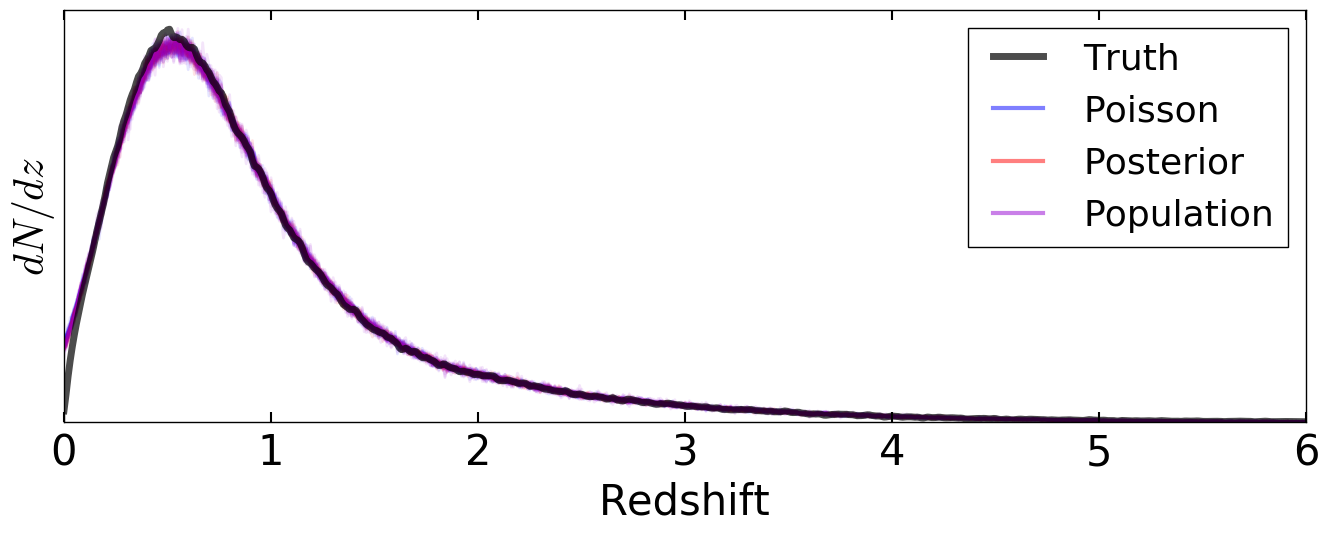

In [138]:
# plotting
figure(figsize=(14,6))
[plot(zgrid, pdf1_samples[i], lw=2, color='blue', alpha=0.1) for i in xrange(Nsamples)]
[plot(zgrid, pdf2_samples[i], lw=2, color='red', alpha=0.1) for i in xrange(Nsamples)]
[plot(zgrid, pdf3_samples[i], lw=2, color='darkviolet', alpha=0.1) for i in xrange(Nsamples)]
plot(zgrid, pdf/pdf.sum() * sdss.NSAMPLES, lw=5, color='black', alpha=0.7, label='Truth')
plot(zgrid, pdf*0.0-1e4, lw=3, color='blue', alpha=0.5, label='Poisson')
plot(zgrid, pdf*0.0-1e4, lw=3, color='red', alpha=0.5, label='Posterior')
plot(zgrid, pdf*0.0-1e4, lw=3, color='darkviolet', alpha=0.5, label='Population')
xlabel('Redshift')
yticks([])
ylim([0, max(pdf/pdf.sum() * sdss.NSAMPLES) * 1.05])
ylabel('$dN/dz$')
legend(fontsize=26, loc='best')
tight_layout()

### Hierarchical Inference

We now use our population weights $\mathbf{w}$ to modify our original posteriors to probe the joint distribution between $\mathbf{w}$ and $\mathbf{n}$.

In [139]:
# burn in
Nburnin = 50
wt = ones(Nz)

for j in xrange(Nburnin):
    sys.stdout.write(str(j)+' ')
    pstack = zeros(Nz)
    for i in xrange(sdss.NSAMPLES):
        p = zpdf[i] * wt # new posterior
        pstack += multinomial(1, p/p.sum()) # stack multinomial draw
    wt = dirichlet(pstack+1) * sdss.NSAMPLES # sample population weight

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 

In [140]:
# generate samples
pdf4_samples = zeros(pdf1_samples.shape)
for j in xrange(Nsamples):
    sys.stdout.write(' -- '+str(j)+' -- ')
    pstack = zeros(Nz)
    for i in xrange(sdss.NSAMPLES):
        if i%100000 == 0: sys.stdout.write(str(i)+' ')
        p = zpdf[i] * wt # compute new posterior
        pstack += multinomial(1, p/p.sum()) # stack multinomial draw
    wt = dirichlet(pstack+1) * sdss.NSAMPLES # sample population weight
    pdf4_samples[j] = wt.copy() # store result

 -- 0 -- 0 100000 200000 300000 400000  -- 1 -- 0 100000 200000 300000 400000  -- 2 -- 0 100000 200000 300000 400000  -- 3 -- 0 100000 200000 300000 400000  -- 4 -- 0 100000 200000 300000 400000  -- 5 -- 0 100000 200000 300000 400000  -- 6 -- 0 100000 200000 300000 400000  -- 7 -- 0 100000 200000 300000 400000  -- 8 -- 0 100000 200000 300000 400000  -- 9 -- 0 100000 200000 300000 400000  -- 10 -- 0 100000 200000 300000 400000  -- 11 -- 0 100000 200000 300000 400000  -- 12 -- 0 100000 200000 300000 400000  -- 13 -- 0 100000 200000 300000 400000  -- 14 -- 0 100000 200000 300000 400000  -- 15 -- 0 100000 200000 300000 400000  -- 16 -- 0 100000 200000 300000 400000  -- 17 -- 0 100000 200000 300000 400000  -- 18 -- 0 100000 200000 300000 400000  -- 19 -- 0 100000 200000 300000 400000 

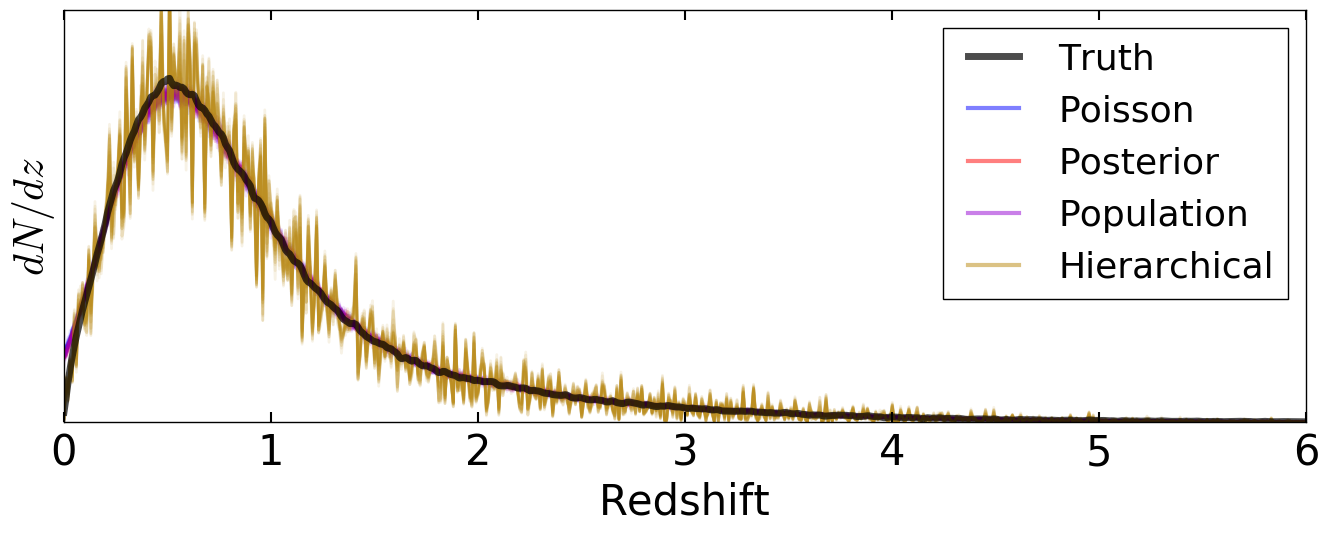

In [146]:
# plotting
figure(figsize=(14,6))
[plot(zgrid, pdf1_samples[i], lw=2, color='blue', alpha=0.1) for i in xrange(Nsamples)]
[plot(zgrid, pdf2_samples[i], lw=2, color='red', alpha=0.1) for i in xrange(Nsamples)]
[plot(zgrid, pdf3_samples[i], lw=2, color='darkviolet', alpha=0.1) for i in xrange(Nsamples)]
[plot(zgrid, pdf4_samples[i], lw=2, color='darkgoldenrod', alpha=0.1) for i in xrange(Nsamples)]
plot(zgrid, pdf/pdf.sum() * sdss.NSAMPLES, lw=5, color='black', alpha=0.7, label='Truth')
plot(zgrid, pdf*0.0-1e4, lw=3, color='blue', alpha=0.5, label='Poisson')
plot(zgrid, pdf*0.0-1e4, lw=3, color='red', alpha=0.5, label='Posterior')
plot(zgrid, pdf*0.0-1e4, lw=3, color='darkviolet', alpha=0.5, label='Population')
plot(zgrid, pdf*0.0-1e4, lw=3, color='darkgoldenrod', alpha=0.5, label='Hierarchical')
xlabel('Redshift')
yticks([])
ylim([0, max(pdf/pdf.sum() * sdss.NSAMPLES) * 1.20])
ylabel('$dN/dz$')
legend(fontsize=26, loc='best')
tight_layout()

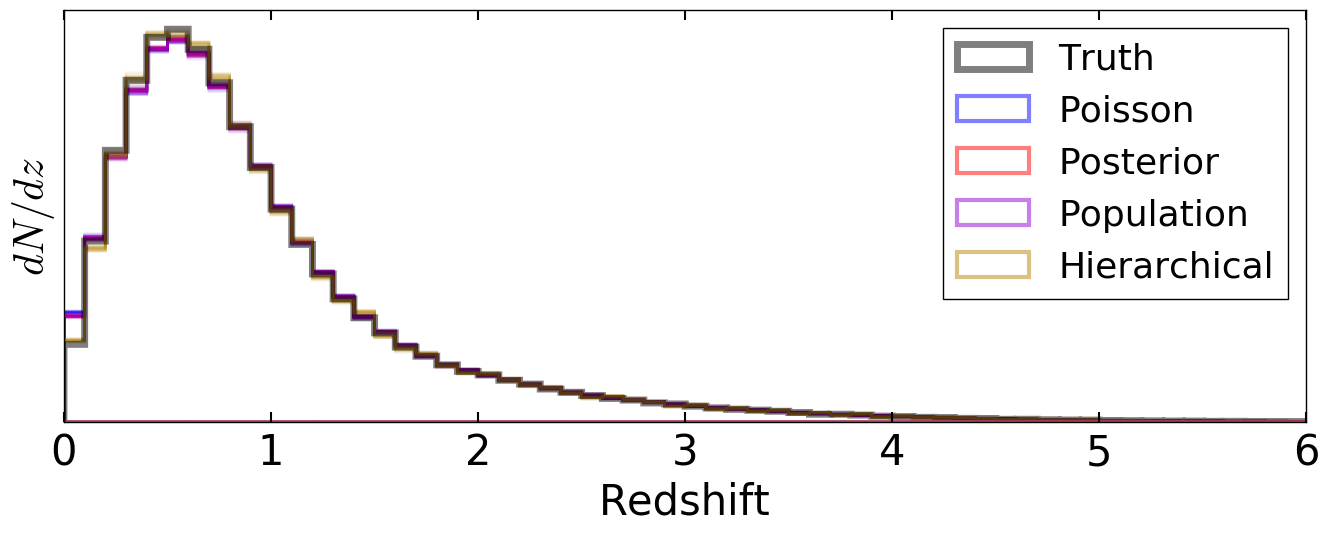

In [162]:
# binning to lower resolution
figure(figsize=(14,6))
[hist(zgrid, zgrid[::10], weights=pdf1_samples[i], lw=2, histtype='step', color='blue', alpha=0.1) 
 for i in xrange(Nsamples)]
[hist(zgrid, zgrid[::10], weights=pdf2_samples[i], lw=2, histtype='step', color='red', alpha=0.1) 
 for i in xrange(Nsamples)]
[hist(zgrid, zgrid[::10], weights=pdf3_samples[i], lw=2, histtype='step', color='darkviolet', alpha=0.1) 
 for i in xrange(Nsamples)]
[hist(zgrid, zgrid[::10], weights=pdf4_samples[i], lw=2, histtype='step', color='darkgoldenrod', alpha=0.1) 
 for i in xrange(Nsamples)]
h = hist(zgrid, zgrid[::10], weights = pdf/pdf.sum() * sdss.NSAMPLES, histtype='step', 
         lw=5, color='black', alpha=0.5, label='Truth')
hist(zgrid, weights=pdf*1e-5, lw=3, histtype='step', color='blue', alpha=0.5, label='Poisson')
hist(zgrid, weights=pdf*1e-5, lw=3, histtype='step', color='red', alpha=0.5, label='Posterior')
hist(zgrid, weights=pdf*1e-5, lw=3, histtype='step', color='darkviolet', alpha=0.5, label='Population')
hist(zgrid, weights=pdf*1e-5, lw=3, histtype='step', color='darkgoldenrod', alpha=0.5, label='Hierarchical')
xlabel('Redshift')
yticks([])
ylim([0, max(h[0]) * 1.05])
ylabel('$dN/dz$')
legend(fontsize=26, loc='best')
tight_layout()

While the errors for our original distributions increase as we transition from our Poisson samples to our posterior draws and our Dirichlet-based population weights, only our hierarchical model is able to properly recover the true underlying distribution.